In [2]:
import pandas as pd

In [4]:
classes_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")

In [5]:
classes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   txId    203769 non-null  int64 
 1   class   203769 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [6]:
classes_df["class"].unique()

array(['unknown', '2', '1'], dtype=object)

In [7]:
fraud_count = len(classes_df[classes_df["class"] == "1"])
normal_count = len(classes_df[classes_df["class"] == "2"])
unknown_count = len(classes_df[classes_df["class"] == "unknown"])
print(f"Fraud Transact: {fraud_count}")
print(f"Normal Transact: {normal_count}")
print(f"Unknown Transact: {unknown_count}")

Fraud Transact: 4545
Normal Transact: 42019
Unknown Transact: 157205


In [8]:
edgelist_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")

In [9]:
edgelist_df.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


# 1. Chain Length & Connectedness Analysis

In [10]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Build directed graph from edgelist
G = nx.from_pandas_edgelist(edgelist_df, source='txId1', target='txId2', create_using=nx.DiGraph())

print(f"Total nodes: {G.number_of_nodes():,}")
print(f"Total edges: {G.number_of_edges():,}")

Total nodes: 203,769
Total edges: 234,355


In [12]:
# Connected components analysis
weakly_connected = list(nx.weakly_connected_components(G))
strongly_connected = list(nx.strongly_connected_components(G))

print(f"Number of weakly connected components: {len(weakly_connected)}")
print(f"Number of strongly connected components: {len(strongly_connected)}")
print(f"\nLargest weakly connected component size: {len(max(weakly_connected, key=len)):,} nodes")
print(f"Largest strongly connected component size: {len(max(strongly_connected, key=len)):,} nodes")

Number of weakly connected components: 49
Number of strongly connected components: 203769

Largest weakly connected component size: 7,880 nodes
Largest strongly connected component size: 1 nodes


In [13]:
# Get largest weakly connected component for further analysis
largest_wcc = G.subgraph(max(weakly_connected, key=len)).copy()

print(f"Analyzing largest weakly connected component ({largest_wcc.number_of_nodes():,} nodes)...")
print(f"Coverage: {largest_wcc.number_of_nodes() / G.number_of_nodes() * 100:.2f}% of all nodes")

Analyzing largest weakly connected component (7,880 nodes)...
Coverage: 3.87% of all nodes


In [14]:
# Average shortest path length (on a sample for efficiency)
# Sample nodes if graph is too large
sample_size = min(1000, largest_wcc.number_of_nodes())
sample_nodes = np.random.choice(list(largest_wcc.nodes()), sample_size, replace=False)

path_lengths = []
for source in sample_nodes[:100]:  # Sample 100 source nodes
    lengths = nx.single_source_shortest_path_length(largest_wcc, source)
    path_lengths.extend(lengths.values())

avg_path_length = np.mean(path_lengths)
max_path_length = np.max(path_lengths)

print(f"Average shortest path length (sampled): {avg_path_length:.2f}")
print(f"Maximum path length in sample: {max_path_length}")

Average shortest path length (sampled): 9.55
Maximum path length in sample: 78


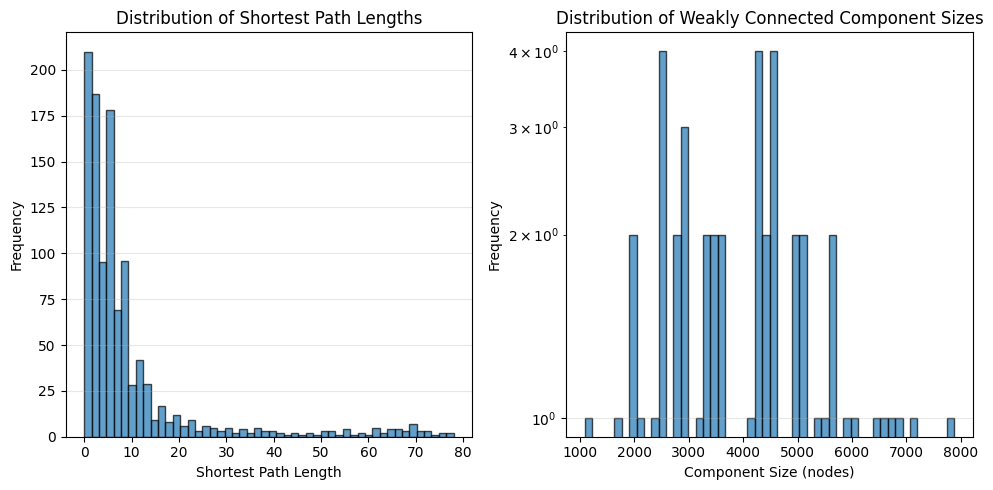

In [15]:
# Visualize path length distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(path_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Shortest Path Length')
plt.ylabel('Frequency')
plt.title('Distribution of Shortest Path Lengths')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
component_sizes = [len(c) for c in weakly_connected]
plt.hist(component_sizes, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Component Size (nodes)')
plt.ylabel('Frequency')
plt.title('Distribution of Weakly Connected Component Sizes')
plt.yscale('log')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Summary statistics
print("="*50)
print("CHAIN LENGTH & CONNECTEDNESS SUMMARY")
print("="*50)
print(f"Graph has {len(weakly_connected)} weakly connected components")
print(f"Largest component contains {len(max(weakly_connected, key=len)) / G.number_of_nodes() * 100:.2f}% of nodes")
print(f"Average path length: {avg_path_length:.2f} hops")
print(f"Graph diameter (sampled): {max_path_length} hops")
print(f"\nInterpretation for GCN:")
if len(max(weakly_connected, key=len)) / G.number_of_nodes() > 0.8:
    print("✓ High connectivity - good for message passing")
else:
    print("⚠ Fragmented graph - may need component-wise training")
if avg_path_length < 10:
    print("✓ Short average paths - signals can propagate efficiently")
else:
    print("⚠ Long paths - may need deeper GCN or risk over-smoothing")

CHAIN LENGTH & CONNECTEDNESS SUMMARY
Graph has 49 weakly connected components
Largest component contains 3.87% of nodes
Average path length: 9.55 hops
Graph diameter (sampled): 78 hops

Interpretation for GCN:
⚠ Fragmented graph - may need component-wise training
✓ Short average paths - signals can propagate efficiently


# 2. Homophily Analysis

In [17]:
# Add node labels to graph
node_labels = dict(zip(classes_df['txId'], classes_df['class']))

# Add labels as node attributes
nx.set_node_attributes(G, node_labels, 'label')

# Check how many nodes have labels
labeled_nodes = [n for n in G.nodes() if G.nodes[n].get('label') in ['1', '2']]
print(f"Nodes with known labels: {len(labeled_nodes):,} / {G.number_of_nodes():,}")
print(f"Labeled coverage: {len(labeled_nodes) / G.number_of_nodes() * 100:.2f}%")

Nodes with known labels: 46,564 / 203,769
Labeled coverage: 22.85%


In [18]:
# Calculate edge homophily - edges connecting same class vs different class
edge_types = {'licit-licit': 0, 'illicit-illicit': 0, 'licit-illicit': 0, 'unknown': 0}

for u, v in G.edges():
    label_u = G.nodes[u].get('label', 'unknown')
    label_v = G.nodes[v].get('label', 'unknown')
    
    if label_u == 'unknown' or label_v == 'unknown':
        edge_types['unknown'] += 1
    elif label_u == '1' and label_v == '1':
        edge_types['illicit-illicit'] += 1
    elif label_u == '2' and label_v == '2':
        edge_types['licit-licit'] += 1
    else:
        edge_types['licit-illicit'] += 1

total_labeled_edges = sum(edge_types.values()) - edge_types['unknown']

print("Edge Type Distribution:")
print(f"  Licit → Licit: {edge_types['licit-licit']:,} ({edge_types['licit-licit']/total_labeled_edges*100:.2f}%)")
print(f"  Illicit → Illicit: {edge_types['illicit-illicit']:,} ({edge_types['illicit-illicit']/total_labeled_edges*100:.2f}%)")
print(f"  Licit ↔ Illicit: {edge_types['licit-illicit']:,} ({edge_types['licit-illicit']/total_labeled_edges*100:.2f}%)")
print(f"  Involving Unknown: {edge_types['unknown']:,}")

Edge Type Distribution:
  Licit → Licit: 33,930 (92.64%)
  Illicit → Illicit: 998 (2.72%)
  Licit ↔ Illicit: 1,696 (4.63%)
  Involving Unknown: 197,731


In [19]:
# Calculate homophily ratio (same-class edges / total edges)
same_class_edges = edge_types['licit-licit'] + edge_types['illicit-illicit']
homophily_ratio = same_class_edges / total_labeled_edges

print(f"\nHomophily Ratio: {homophily_ratio:.3f}")
print(f"  (1.0 = perfect homophily, 0.0 = no homophily)")

# Expected homophily under random mixing
illicit_count = len([n for n in labeled_nodes if G.nodes[n]['label'] == '1'])
licit_count = len([n for n in labeled_nodes if G.nodes[n]['label'] == '2'])
total_labeled = licit_count + illicit_count

p_licit = licit_count / total_labeled
p_illicit = illicit_count / total_labeled
expected_homophily = p_licit**2 + p_illicit**2

print(f"\nExpected homophily (random): {expected_homophily:.3f}")
print(f"Actual homophily: {homophily_ratio:.3f}")
print(f"Excess homophily: {homophily_ratio - expected_homophily:.3f}")


Homophily Ratio: 0.954
  (1.0 = perfect homophily, 0.0 = no homophily)

Expected homophily (random): 0.824
Actual homophily: 0.954
Excess homophily: 0.130


In [20]:
# Assortativity coefficient (measures tendency of similar nodes to connect)
# Only consider labeled nodes
labeled_subgraph = G.subgraph(labeled_nodes).copy()

# Convert labels to numeric for assortativity calculation
label_mapping = {'1': 1, '2': 0}  # 1=illicit, 2=licit
numeric_labels = {n: label_mapping[labeled_subgraph.nodes[n]['label']] 
                  for n in labeled_subgraph.nodes()}
nx.set_node_attributes(labeled_subgraph, numeric_labels, 'numeric_label')

assortativity = nx.attribute_assortativity_coefficient(labeled_subgraph, 'numeric_label')
print(f"\nAssortativity Coefficient: {assortativity:.3f}")
print(f"  (+1 = perfect assortative mixing, -1 = perfect disassortative mixing, 0 = random)")

if assortativity > 0.3:
    print("  → Strong homophily detected!")
elif assortativity > 0.1:
    print("  → Moderate homophily detected")
else:
    print("  → Weak or no homophily")


Assortativity Coefficient: 0.516
  (+1 = perfect assortative mixing, -1 = perfect disassortative mixing, 0 = random)
  → Strong homophily detected!


In [21]:
# Neighbor label distribution - what % of neighbors share the same label?
neighbor_same_label_pct = []

for node in labeled_nodes:
    node_label = G.nodes[node]['label']
    neighbors = list(G.neighbors(node)) + list(G.predecessors(node))
    
    if len(neighbors) == 0:
        continue
    
    same_label_neighbors = sum(1 for n in neighbors if G.nodes[n].get('label') == node_label)
    neighbor_same_label_pct.append(same_label_neighbors / len(neighbors))

avg_neighbor_homophily = np.mean(neighbor_same_label_pct)
print(f"\nAverage % of neighbors with same label: {avg_neighbor_homophily*100:.2f}%")
print(f"  (Higher % = neighbors are predictive of node label)")


Average % of neighbors with same label: 59.20%
  (Higher % = neighbors are predictive of node label)


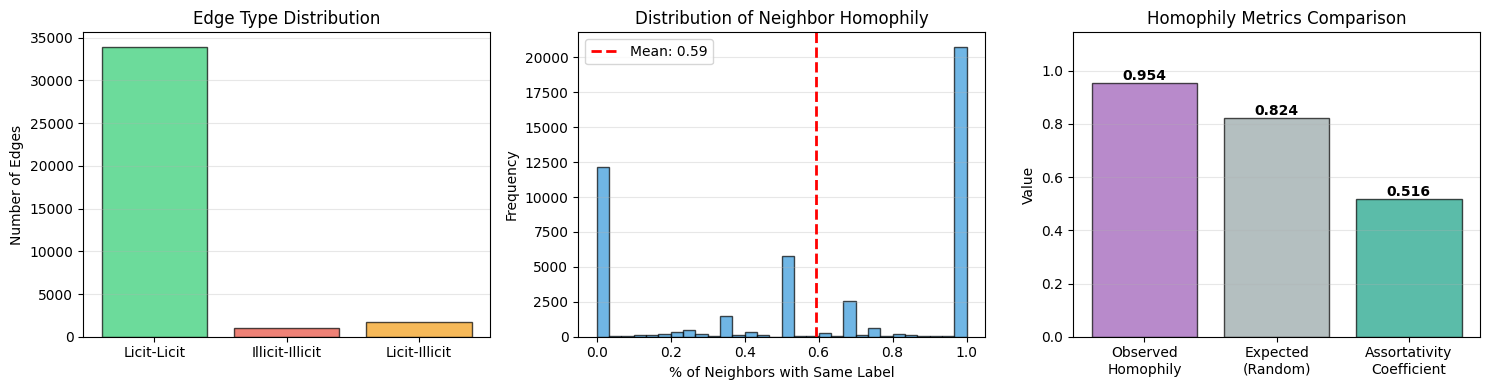

In [22]:
# Visualize homophily patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Edge type distribution
ax = axes[0]
edge_labels = ['Licit-Licit', 'Illicit-Illicit', 'Licit-Illicit']
edge_counts = [edge_types['licit-licit'], edge_types['illicit-illicit'], edge_types['licit-illicit']]
colors = ['#2ecc71', '#e74c3c', '#f39c12']
ax.bar(edge_labels, edge_counts, color=colors, edgecolor='black', alpha=0.7)
ax.set_ylabel('Number of Edges')
ax.set_title('Edge Type Distribution')
ax.grid(axis='y', alpha=0.3)

# Neighbor homophily distribution
ax = axes[1]
ax.hist(neighbor_same_label_pct, bins=30, edgecolor='black', alpha=0.7, color='#3498db')
ax.axvline(avg_neighbor_homophily, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_neighbor_homophily:.2f}')
ax.set_xlabel('% of Neighbors with Same Label')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Neighbor Homophily')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Homophily comparison
ax = axes[2]
metrics = ['Observed\nHomophily', 'Expected\n(Random)', 'Assortativity\nCoefficient']
values = [homophily_ratio, expected_homophily, assortativity]
bars = ax.bar(metrics, values, color=['#9b59b6', '#95a5a6', '#16a085'], edgecolor='black', alpha=0.7)
ax.set_ylabel('Value')
ax.set_title('Homophily Metrics Comparison')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, max(values) * 1.2])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [23]:
# Summary and interpretation
print("="*50)
print("HOMOPHILY ANALYSIS SUMMARY")
print("="*50)
print(f"Homophily Ratio: {homophily_ratio:.3f}")
print(f"Assortativity Coefficient: {assortativity:.3f}")
print(f"Avg % Neighbors Same Label: {avg_neighbor_homophily*100:.2f}%")
print(f"\nInterpretation for GCN:")

if assortativity > 0.2:
    print("✓ Strong homophily - GCNs will benefit from message passing")
    print("  Fraudulent nodes cluster together, making them easier to detect")
elif assortativity > 0.1:
    print("✓ Moderate homophily - GCNs are suitable")
    print("  Neighbor information provides useful signal")
else:
    print("⚠ Weak homophily - GCNs may not benefit much from graph structure")
    print("  Consider heterophily-aware architectures or focus on node features")

if edge_types['licit-illicit'] / total_labeled_edges > 0.3:
    print("⚠ High cross-class edges - fraud may involve mixing with legitimate transactions")
    print("  This is realistic for fraud detection (money laundering patterns)")

HOMOPHILY ANALYSIS SUMMARY
Homophily Ratio: 0.954
Assortativity Coefficient: 0.516
Avg % Neighbors Same Label: 59.20%

Interpretation for GCN:
✓ Strong homophily - GCNs will benefit from message passing
  Fraudulent nodes cluster together, making them easier to detect


# 3. Degree Distribution Analysis

In [24]:
# Calculate degree statistics
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
total_degrees = dict(G.degree())

in_deg_values = list(in_degrees.values())
out_deg_values = list(out_degrees.values())
total_deg_values = list(total_degrees.values())

print("Overall Degree Statistics:")
print(f"  In-degree  - Mean: {np.mean(in_deg_values):.2f}, Median: {np.median(in_deg_values):.0f}, Max: {np.max(in_deg_values)}")
print(f"  Out-degree - Mean: {np.mean(out_deg_values):.2f}, Median: {np.median(out_deg_values):.0f}, Max: {np.max(out_deg_values)}")
print(f"  Total      - Mean: {np.mean(total_deg_values):.2f}, Median: {np.median(total_deg_values):.0f}, Max: {np.max(total_deg_values)}")

Overall Degree Statistics:
  In-degree  - Mean: 1.15, Median: 1, Max: 284
  Out-degree - Mean: 1.15, Median: 1, Max: 472
  Total      - Mean: 2.30, Median: 2, Max: 473


In [25]:
# Degree distribution by class (licit vs illicit)
illicit_nodes = [n for n in labeled_nodes if G.nodes[n]['label'] == '1']  # class 1 = illicit
licit_nodes = [n for n in labeled_nodes if G.nodes[n]['label'] == '2']  # class 2 = licit

licit_in_deg = [in_degrees[n] for n in licit_nodes]
licit_out_deg = [out_degrees[n] for n in licit_nodes]
illicit_in_deg = [in_degrees[n] for n in illicit_nodes]
illicit_out_deg = [out_degrees[n] for n in illicit_nodes]

print("\nDegree Statistics by Class:")
print(f"\nLicit Transactions (n={len(licit_nodes):,}):")
print(f"  In-degree  - Mean: {np.mean(licit_in_deg):.2f}, Median: {np.median(licit_in_deg):.0f}")
print(f"  Out-degree - Mean: {np.mean(licit_out_deg):.2f}, Median: {np.median(licit_out_deg):.0f}")

print(f"\nIllicit Transactions (n={len(illicit_nodes):,}):")
print(f"  In-degree  - Mean: {np.mean(illicit_in_deg):.2f}, Median: {np.median(illicit_in_deg):.0f}")
print(f"  Out-degree - Mean: {np.mean(illicit_out_deg):.2f}, Median: {np.median(illicit_out_deg):.0f}")


Degree Statistics by Class:

Licit Transactions (n=42,019):
  In-degree  - Mean: 1.91, Median: 1
  Out-degree - Mean: 1.19, Median: 1

Illicit Transactions (n=4,545):
  In-degree  - Mean: 1.27, Median: 1
  Out-degree - Mean: 0.74, Median: 1


In [26]:
# Check for power-law distribution (common in scale-free networks)
from scipy import stats

# Remove zeros for power-law fitting
total_deg_nonzero = [d for d in total_deg_values if d > 0]

# Fit power law to degree distribution
def estimate_power_law_exponent(degrees):
    """Estimate power law exponent using maximum likelihood"""
    degrees = np.array([d for d in degrees if d > 0])
    if len(degrees) == 0:
        return None
    # MLE estimator: alpha = 1 + n / sum(ln(x_i / x_min))
    x_min = np.min(degrees)
    alpha = 1 + len(degrees) / np.sum(np.log(degrees / x_min))
    return alpha

alpha = estimate_power_law_exponent(total_deg_nonzero)
print(f"\nPower-law exponent (alpha): {alpha:.2f}")
print(f"  (Typical scale-free networks: 2 < alpha < 3)")

if 2 < alpha < 3:
    print("  → Network shows scale-free properties (few hubs, many low-degree nodes)")
else:
    print("  → Network may not follow pure power-law distribution")


Power-law exponent (alpha): 2.69
  (Typical scale-free networks: 2 < alpha < 3)
  → Network shows scale-free properties (few hubs, many low-degree nodes)


In [27]:
# Identify hub nodes (high degree nodes)
degree_threshold_95 = np.percentile(total_deg_values, 95)
hub_nodes = [n for n, d in total_degrees.items() if d >= degree_threshold_95]

print(f"\nHub Analysis (top 5% by degree):")
print(f"  Degree threshold: {degree_threshold_95:.0f}")
print(f"  Number of hubs: {len(hub_nodes):,}")

# Check class distribution of hubs
hub_labels = [G.nodes[n].get('label', 'unknown') for n in hub_nodes]
hub_illicit = sum(1 for l in hub_labels if l == '1')
hub_licit = sum(1 for l in hub_labels if l == '2')
hub_unknown = sum(1 for l in hub_labels if l == 'unknown')

print(f"\nHub node class distribution:")
print(f"  Licit: {hub_licit} ({hub_licit/len(hub_nodes)*100:.1f}%)")
print(f"  Illicit: {hub_illicit} ({hub_illicit/len(hub_nodes)*100:.1f}%)")
print(f"  Unknown: {hub_unknown} ({hub_unknown/len(hub_nodes)*100:.1f}%)")


Hub Analysis (top 5% by degree):
  Degree threshold: 4
  Number of hubs: 13,752

Hub node class distribution:
  Licit: 5812 (42.3%)
  Illicit: 102 (0.7%)
  Unknown: 7838 (57.0%)


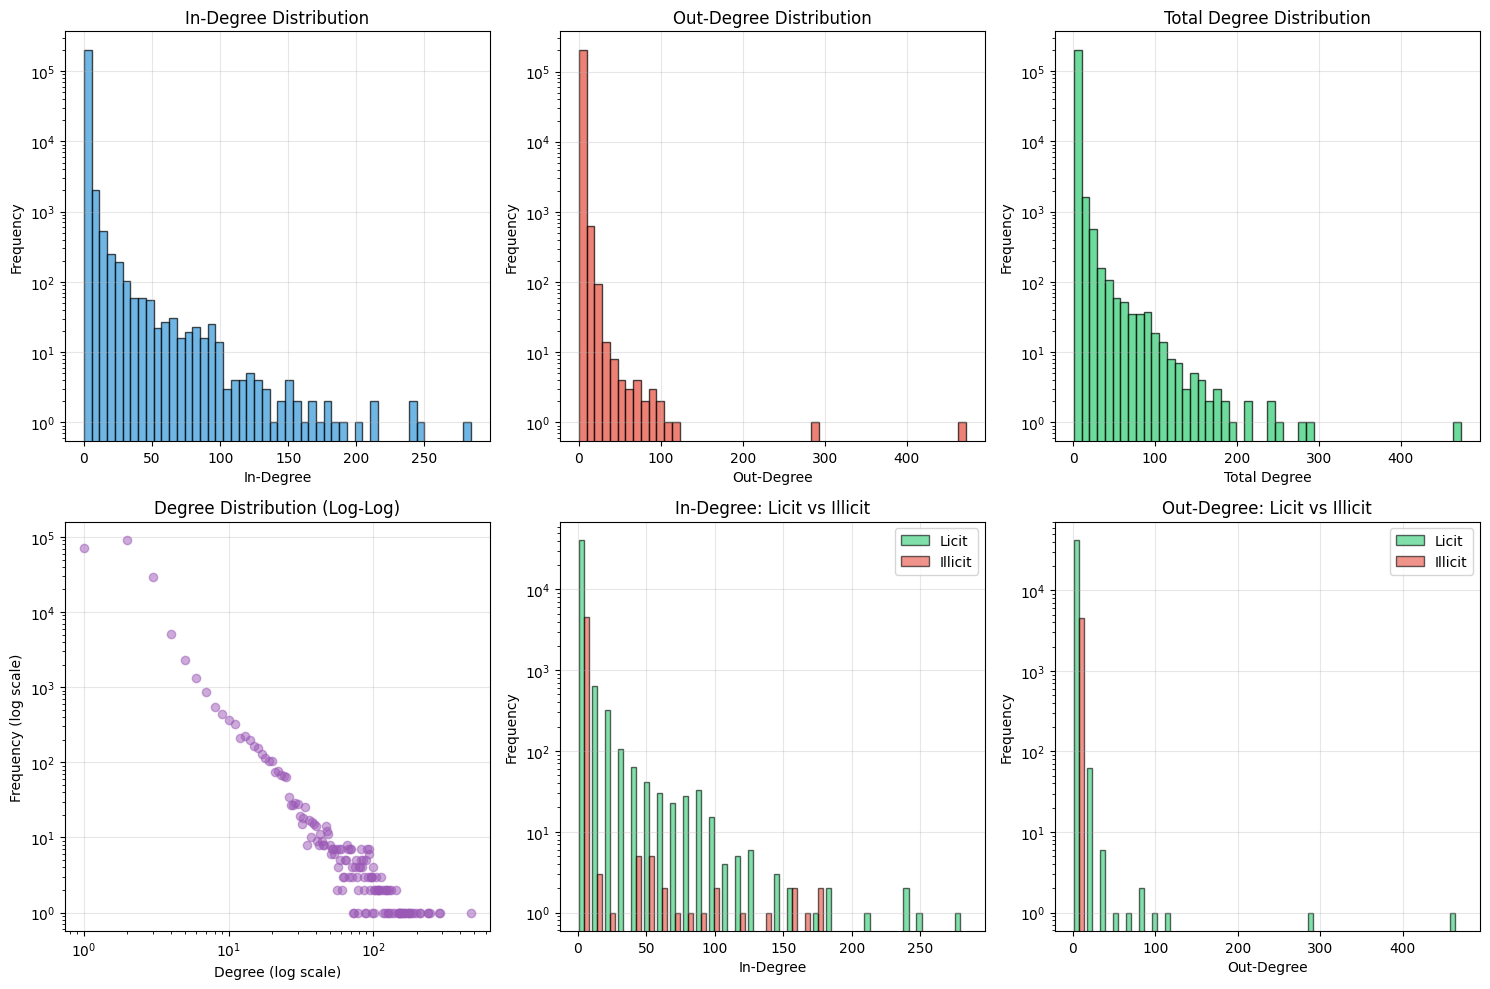

In [28]:
# Visualize degree distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Overall degree distributions (log-log scale to check power law)
ax = axes[0, 0]
ax.hist(in_deg_values, bins=50, edgecolor='black', alpha=0.7, color='#3498db')
ax.set_xlabel('In-Degree')
ax.set_ylabel('Frequency')
ax.set_title('In-Degree Distribution')
ax.set_yscale('log')
ax.grid(alpha=0.3)

ax = axes[0, 1]
ax.hist(out_deg_values, bins=50, edgecolor='black', alpha=0.7, color='#e74c3c')
ax.set_xlabel('Out-Degree')
ax.set_ylabel('Frequency')
ax.set_title('Out-Degree Distribution')
ax.set_yscale('log')
ax.grid(alpha=0.3)

ax = axes[0, 2]
ax.hist(total_deg_values, bins=50, edgecolor='black', alpha=0.7, color='#2ecc71')
ax.set_xlabel('Total Degree')
ax.set_ylabel('Frequency')
ax.set_title('Total Degree Distribution')
ax.set_yscale('log')
ax.grid(alpha=0.3)

# Log-log plot to check power law
ax = axes[1, 0]
degree_counts = np.bincount(total_deg_values)
degrees = np.nonzero(degree_counts)[0]
counts = degree_counts[degrees]
ax.loglog(degrees, counts, 'o', alpha=0.5, color='#9b59b6')
ax.set_xlabel('Degree (log scale)')
ax.set_ylabel('Frequency (log scale)')
ax.set_title('Degree Distribution (Log-Log)')
ax.grid(alpha=0.3)

# Compare licit vs illicit in-degree
ax = axes[1, 1]
ax.hist([licit_in_deg, illicit_in_deg], bins=30, label=['Licit', 'Illicit'], 
        color=['#2ecc71', '#e74c3c'], alpha=0.6, edgecolor='black')
ax.set_xlabel('In-Degree')
ax.set_ylabel('Frequency')
ax.set_title('In-Degree: Licit vs Illicit')
ax.set_yscale('log')
ax.legend()
ax.grid(alpha=0.3)

# Compare licit vs illicit out-degree
ax = axes[1, 2]
ax.hist([licit_out_deg, illicit_out_deg], bins=30, label=['Licit', 'Illicit'], 
        color=['#2ecc71', '#e74c3c'], alpha=0.6, edgecolor='black')
ax.set_xlabel('Out-Degree')
ax.set_ylabel('Frequency')
ax.set_title('Out-Degree: Licit vs Illicit')
ax.set_yscale('log')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Statistical test: Do licit and illicit nodes have different degree distributions?
from scipy.stats import mannwhitneyu

# Mann-Whitney U test (non-parametric test for different distributions)
stat_in, p_in = mannwhitneyu(licit_in_deg, illicit_in_deg, alternative='two-sided')
stat_out, p_out = mannwhitneyu(licit_out_deg, illicit_out_deg, alternative='two-sided')

print("\nStatistical Test: Licit vs Illicit Degree Distributions")
print(f"In-degree:  p-value = {p_in:.4f}", "→ Significantly different!" if p_in < 0.05 else "→ Not significantly different")
print(f"Out-degree: p-value = {p_out:.4f}", "→ Significantly different!" if p_out < 0.05 else "→ Not significantly different")

if p_in < 0.05 or p_out < 0.05:
    print("\n→ Degree can be a discriminative feature for fraud detection!")


Statistical Test: Licit vs Illicit Degree Distributions
In-degree:  p-value = 0.0000 → Significantly different!
Out-degree: p-value = 0.0000 → Significantly different!

→ Degree can be a discriminative feature for fraud detection!


In [30]:
# Summary and interpretation
print("="*50)
print("DEGREE DISTRIBUTION SUMMARY")
print("="*50)
print(f"Average degree: {np.mean(total_deg_values):.2f}")
print(f"Power-law exponent: {alpha:.2f}")
print(f"Hub nodes (top 5%): {len(hub_nodes):,}")
print(f"\nDegree differences (Licit vs Illicit):")
print(f"  In-degree:  {np.mean(licit_in_deg):.2f} vs {np.mean(illicit_in_deg):.2f}")
print(f"  Out-degree: {np.mean(licit_out_deg):.2f} vs {np.mean(illicit_out_deg):.2f}")

print(f"\nInterpretation for GCN:")

if 2 < alpha < 3:
    print("✓ Scale-free network - GCNs can leverage hub nodes for information propagation")
    print("  Hub nodes act as bridges, spreading information efficiently")
else:
    print("⚠ Not a typical scale-free network")
    
if p_in < 0.05 or p_out < 0.05:
    print("✓ Degree distributions differ by class - structural features are predictive")
    print("  GCNs can exploit these differences through message passing")
else:
    print("⚠ Degree distributions are similar - may need to rely more on node features")

if np.mean(total_deg_values) < 5:
    print("⚠ Sparse graph - may benefit from graph sampling or mini-batching strategies")
elif np.mean(total_deg_values) > 20:
    print("⚠ Dense neighborhoods - consider neighbor sampling to reduce computational cost")

DEGREE DISTRIBUTION SUMMARY
Average degree: 2.30
Power-law exponent: 2.69
Hub nodes (top 5%): 13,752

Degree differences (Licit vs Illicit):
  In-degree:  1.91 vs 1.27
  Out-degree: 1.19 vs 0.74

Interpretation for GCN:
✓ Scale-free network - GCNs can leverage hub nodes for information propagation
  Hub nodes act as bridges, spreading information efficiently
✓ Degree distributions differ by class - structural features are predictive
  GCNs can exploit these differences through message passing
⚠ Sparse graph - may benefit from graph sampling or mini-batching strategies


# 4. Community Structure Analysis

In [31]:
# Community detection using Louvain algorithm
# Convert to undirected for community detection
G_undirected = G.to_undirected()

print("Running Louvain community detection...")
import community.community_louvain as community_louvain

# Detect communities
communities = community_louvain.best_partition(G_undirected)

# Add community assignments to nodes
nx.set_node_attributes(G, communities, 'community')

n_communities = len(set(communities.values()))
print(f"Number of communities detected: {n_communities}")

Running Louvain community detection...
Number of communities detected: 308


In [32]:
# Calculate modularity score
modularity = community_louvain.modularity(communities, G_undirected)
print(f"Modularity score: {modularity:.3f}")
print(f"  (>0.3 = strong community structure, 0.3-0.7 = good, >0.7 = very strong)")

if modularity > 0.3:
    print("  → Strong community structure detected!")
else:
    print("  → Weak community structure")

Modularity score: 0.980
  (>0.3 = strong community structure, 0.3-0.7 = good, >0.7 = very strong)
  → Strong community structure detected!


In [33]:
# Analyze community sizes
community_sizes = {}
for node, comm in communities.items():
    community_sizes[comm] = community_sizes.get(comm, 0) + 1

sizes = list(community_sizes.values())
print(f"\nCommunity size statistics:")
print(f"  Mean size: {np.mean(sizes):.2f}")
print(f"  Median size: {np.median(sizes):.0f}")
print(f"  Largest community: {np.max(sizes):,} nodes")
print(f"  Smallest community: {np.min(sizes)} nodes")
print(f"\nTop 5 largest communities:")
top_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:5]
for comm_id, size in top_communities:
    print(f"  Community {comm_id}: {size:,} nodes ({size/G.number_of_nodes()*100:.2f}%)")


Community size statistics:
  Mean size: 661.59
  Median size: 72
  Largest community: 6,670 nodes
  Smallest community: 17 nodes

Top 5 largest communities:
  Community 271: 6,670 nodes (3.27%)
  Community 43: 6,049 nodes (2.97%)
  Community 71: 5,758 nodes (2.83%)
  Community 227: 5,645 nodes (2.77%)
  Community 302: 5,488 nodes (2.69%)


In [34]:
# Analyze label purity within communities (key metric for fraud detection!)
# For each community, calculate what % of labeled nodes are illicit

community_label_stats = {}

for comm_id in set(communities.values()):
    # Get nodes in this community
    comm_nodes = [n for n, c in communities.items() if c == comm_id]
    
    # Count labels
    labels_in_comm = [G.nodes[n].get('label', 'unknown') for n in comm_nodes]
    illicit = sum(1 for l in labels_in_comm if l == '1')  # class 1 = illicit
    licit = sum(1 for l in labels_in_comm if l == '2')  # class 2 = licit
    unknown = sum(1 for l in labels_in_comm if l == 'unknown')
    
    total_labeled = licit + illicit
    if total_labeled > 0:
        illicit_pct = illicit / total_labeled
        community_label_stats[comm_id] = {
            'size': len(comm_nodes),
            'licit': licit,
            'illicit': illicit,
            'unknown': unknown,
            'illicit_pct': illicit_pct,
            'purity': max(licit, illicit) / total_labeled if total_labeled > 0 else 0
        }

print("\nCommunity label purity analysis:")
print(f"Total communities with labeled nodes: {len(community_label_stats)}")

# Find pure communities (>80% one class)
pure_licit = sum(1 for stats in community_label_stats.values() if stats['illicit_pct'] < 0.2)
pure_illicit = sum(1 for stats in community_label_stats.values() if stats['illicit_pct'] > 0.8)
mixed = len(community_label_stats) - pure_licit - pure_illicit

print(f"  Pure licit communities (<20% illicit): {pure_licit}")
print(f"  Pure illicit communities (>80% illicit): {pure_illicit}")
print(f"  Mixed communities: {mixed}")


Community label purity analysis:
Total communities with labeled nodes: 229
  Pure licit communities (<20% illicit): 195
  Pure illicit communities (>80% illicit): 6
  Mixed communities: 28


In [35]:
# Calculate average purity across all communities
avg_purity = np.mean([stats['purity'] for stats in community_label_stats.values()])
print(f"\nAverage community purity: {avg_purity:.3f}")
print(f"  (1.0 = perfect separation of classes into communities)")

# Show most illicit communities
print("\nTop 5 most illicit communities:")
sorted_by_illicit = sorted(community_label_stats.items(), 
                           key=lambda x: x[1]['illicit_pct'], reverse=True)[:5]
for comm_id, stats in sorted_by_illicit:
    if stats['licit'] + stats['illicit'] > 10:  # Only show if enough labeled nodes
        print(f"  Community {comm_id}: {stats['illicit_pct']*100:.1f}% illicit "
              f"({stats['illicit']}/{stats['licit']+stats['illicit']} labeled nodes, "
              f"size={stats['size']})")


Average community purity: 0.937
  (1.0 = perfect separation of classes into communities)

Top 5 most illicit communities:
  Community 146: 100.0% illicit (23/23 labeled nodes, size=39)
  Community 191: 95.0% illicit (114/120 labeled nodes, size=121)


In [36]:
# Clustering coefficient - measures local clustering tendency
avg_clustering = nx.average_clustering(G_undirected)
print(f"\nAverage clustering coefficient: {avg_clustering:.3f}")
print(f"  (Measures tendency of nodes to form triangles/clusters)")

# Compare with random graph
# Random graph clustering coefficient ~ average_degree / num_nodes
expected_clustering = np.mean(total_deg_values) / G.number_of_nodes()
print(f"Expected clustering (random graph): {expected_clustering:.4f}")
print(f"Actual / Expected ratio: {avg_clustering / expected_clustering:.2f}x")

if avg_clustering / expected_clustering > 5:
    print("  → Strong clustering - much higher than random!")
elif avg_clustering / expected_clustering > 2:
    print("  → Moderate clustering")
else:
    print("  → Weak clustering")


Average clustering coefficient: 0.014
  (Measures tendency of nodes to form triangles/clusters)
Expected clustering (random graph): 0.0000
Actual / Expected ratio: 1219.16x
  → Strong clustering - much higher than random!


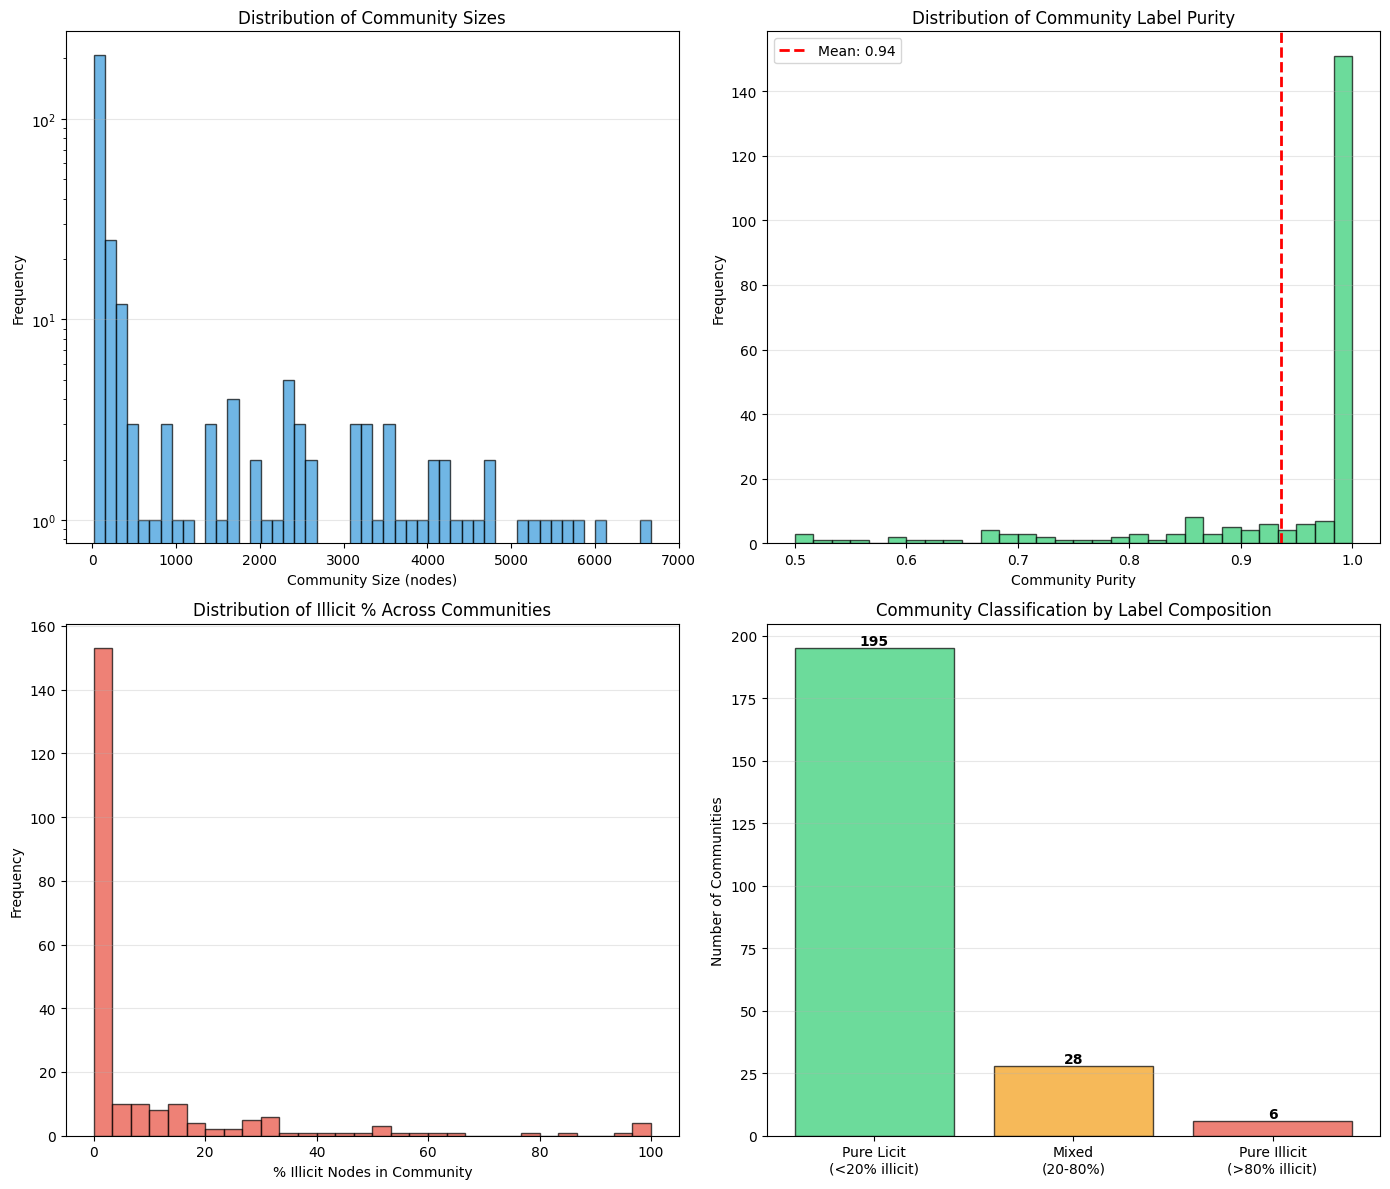

In [37]:
# Visualize community structure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Community size distribution
ax = axes[0, 0]
ax.hist(sizes, bins=50, edgecolor='black', alpha=0.7, color='#3498db')
ax.set_xlabel('Community Size (nodes)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Community Sizes')
ax.set_yscale('log')
ax.grid(axis='y', alpha=0.3)

# Community purity distribution
ax = axes[0, 1]
purities = [stats['purity'] for stats in community_label_stats.values()]
ax.hist(purities, bins=30, edgecolor='black', alpha=0.7, color='#2ecc71')
ax.axvline(avg_purity, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {avg_purity:.2f}')
ax.set_xlabel('Community Purity')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Community Label Purity')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Illicit percentage per community
ax = axes[1, 0]
illicit_pcts = [stats['illicit_pct']*100 for stats in community_label_stats.values()]
ax.hist(illicit_pcts, bins=30, edgecolor='black', alpha=0.7, color='#e74c3c')
ax.set_xlabel('% Illicit Nodes in Community')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Illicit % Across Communities')
ax.grid(axis='y', alpha=0.3)

# Community type breakdown
ax = axes[1, 1]
categories = ['Pure Licit\n(<20% illicit)', 'Mixed\n(20-80%)', 'Pure Illicit\n(>80% illicit)']
counts = [pure_licit, mixed, pure_illicit]
colors = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax.bar(categories, counts, color=colors, edgecolor='black', alpha=0.7)
ax.set_ylabel('Number of Communities')
ax.set_title('Community Classification by Label Composition')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [38]:
# Summary and interpretation
print("="*50)
print("COMMUNITY STRUCTURE SUMMARY")
print("="*50)
print(f"Number of communities: {n_communities}")
print(f"Modularity: {modularity:.3f}")
print(f"Average clustering coefficient: {avg_clustering:.3f}")
print(f"Community purity: {avg_purity:.3f}")
print(f"\nCommunity composition:")
print(f"  Pure licit: {pure_licit} ({pure_licit/len(community_label_stats)*100:.1f}%)")
print(f"  Mixed: {mixed} ({mixed/len(community_label_stats)*100:.1f}%)")
print(f"  Pure illicit: {pure_illicit} ({pure_illicit/len(community_label_stats)*100:.1f}%)")

print(f"\nInterpretation for GCN & Community Detection:")

if modularity > 0.3:
    print("✓ Strong community structure detected")
    if avg_purity > 0.7:
        print("✓ Communities align well with fraud labels - excellent signal!")
        print("  → Community detection features will be highly predictive")
        print("  → GCNs can exploit community membership for classification")
    elif avg_purity > 0.5:
        print("✓ Moderate alignment between communities and labels")
        print("  → Community features will provide useful signal")
    else:
        print("⚠ Communities don't align well with fraud labels")
        print("  → Communities may represent other patterns (exchanges, mixers, etc.)")
else:
    print("⚠ Weak community structure")
    print("  → May not benefit much from explicit community detection")

if pure_illicit > 0:
    print(f"✓ Found {pure_illicit} pure illicit communities - potential fraud rings!")
    print("  → These could be money laundering networks or coordinated fraud")
    
if avg_clustering > 0.1:
    print("✓ High clustering - graph has small-world properties")
    print("  → Ideal for GCNs (short paths + high clustering)")

COMMUNITY STRUCTURE SUMMARY
Number of communities: 308
Modularity: 0.980
Average clustering coefficient: 0.014
Community purity: 0.937

Community composition:
  Pure licit: 195 (85.2%)
  Mixed: 28 (12.2%)
  Pure illicit: 6 (2.6%)

Interpretation for GCN & Community Detection:
✓ Strong community structure detected
✓ Communities align well with fraud labels - excellent signal!
  → Community detection features will be highly predictive
  → GCNs can exploit community membership for classification
✓ Found 6 pure illicit communities - potential fraud rings!
  → These could be money laundering networks or coordinated fraud


## Graph Visualization

In [39]:
# Sample a subgraph for visualization (full graph is too large)
# We'll sample around some high-degree nodes to see interesting structure

def sample_ego_subgraph(G, center_nodes, radius=2):
    """Sample subgraph around center nodes with given radius"""
    sampled_nodes = set()
    for center in center_nodes:
        # Get nodes within radius
        for node in nx.single_source_shortest_path_length(G, center, cutoff=radius).keys():
            sampled_nodes.add(node)
    return G.subgraph(sampled_nodes).copy()

# Sample around top degree nodes from different communities
high_degree_nodes = sorted(total_degrees.items(), key=lambda x: x[1], reverse=True)

# Select diverse nodes (from different communities if possible)
sample_centers = []
seen_communities = set()
for node, degree in high_degree_nodes:
    if len(sample_centers) >= 5:
        break
    comm = communities.get(node)
    if comm not in seen_communities:
        sample_centers.append(node)
        seen_communities.add(comm)

# If we don't have enough, just take top degree nodes
if len(sample_centers) < 5:
    sample_centers = [node for node, _ in high_degree_nodes[:5]]

print(f"Sampling subgraph around {len(sample_centers)} high-degree nodes...")
G_sample = sample_ego_subgraph(G, sample_centers, radius=2)
print(f"Sampled subgraph: {G_sample.number_of_nodes()} nodes, {G_sample.number_of_edges()} edges")

Sampling subgraph around 5 high-degree nodes...
Sampled subgraph: 1129 nodes, 1348 edges


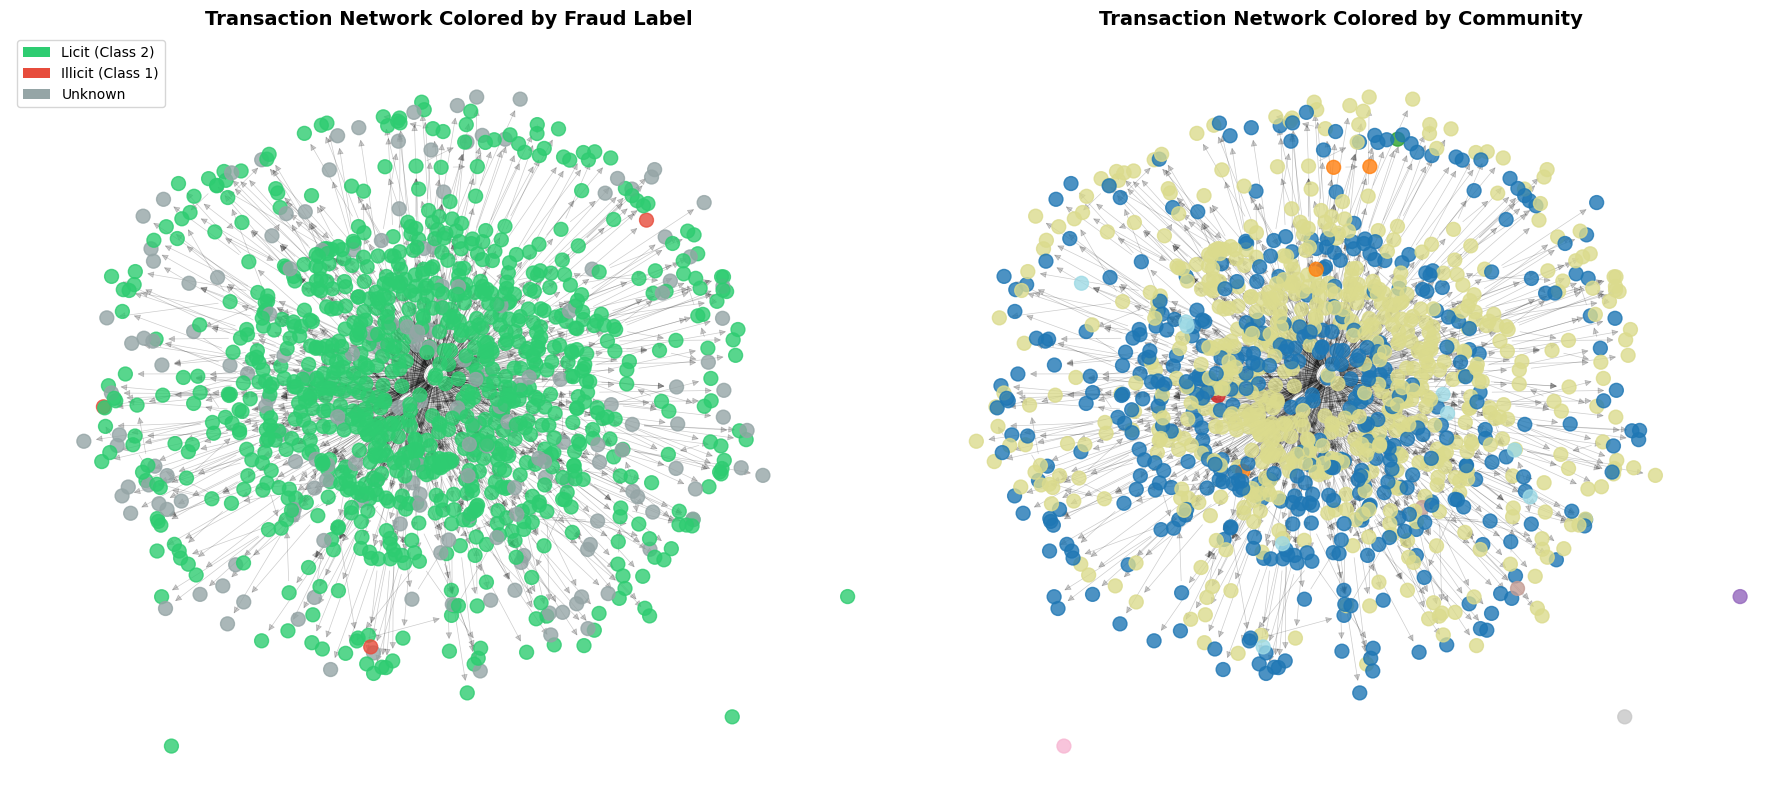


Visualization shows 1129 nodes from the transaction network
Left: Nodes colored by fraud label (green=licit/class 2, red=illicit/class 1, gray=unknown)
Right: Nodes colored by detected community


In [40]:
# Visualization 1: Color nodes by their fraud label
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Layout for visualization
pos = nx.spring_layout(G_sample, k=0.5, iterations=50, seed=42)

# Plot 1: Colored by fraud label
ax = axes[0]
node_colors = []
for node in G_sample.nodes():
    label = G_sample.nodes[node].get('label', 'unknown')
    if label == '1':
        node_colors.append('#e74c3c')  # Red for illicit (class 1)
    elif label == '2':
        node_colors.append('#2ecc71')  # Green for licit (class 2)
    else:
        node_colors.append('#95a5a6')  # Gray for unknown

nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors, node_size=100, 
                       alpha=0.8, ax=ax)
nx.draw_networkx_edges(G_sample, pos, alpha=0.2, arrows=True, 
                       arrowsize=10, width=0.5, ax=ax)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Licit (Class 2)'),
    Patch(facecolor='#e74c3c', label='Illicit (Class 1)'),
    Patch(facecolor='#95a5a6', label='Unknown')
]
ax.legend(handles=legend_elements, loc='upper left')
ax.set_title('Transaction Network Colored by Fraud Label', fontsize=14, fontweight='bold')
ax.axis('off')

# Plot 2: Colored by community
ax = axes[1]
community_colors = []
unique_communities = list(set(communities[node] for node in G_sample.nodes() if node in communities))
color_map = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
comm_to_color = {comm: color_map[i] for i, comm in enumerate(unique_communities)}

for node in G_sample.nodes():
    comm = communities.get(node, -1)
    if comm in comm_to_color:
        community_colors.append(comm_to_color[comm])
    else:
        community_colors.append('#95a5a6')

nx.draw_networkx_nodes(G_sample, pos, node_color=community_colors, node_size=100, 
                       alpha=0.8, ax=ax)
nx.draw_networkx_edges(G_sample, pos, alpha=0.2, arrows=True, 
                       arrowsize=10, width=0.5, ax=ax)

ax.set_title('Transaction Network Colored by Community', fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nVisualization shows {G_sample.number_of_nodes()} nodes from the transaction network")
print("Left: Nodes colored by fraud label (green=licit/class 2, red=illicit/class 1, gray=unknown)")
print("Right: Nodes colored by detected community")


Visualizing pure illicit community 146
  Size: 39 nodes (showing first 100)
  Illicit %: 100.0%


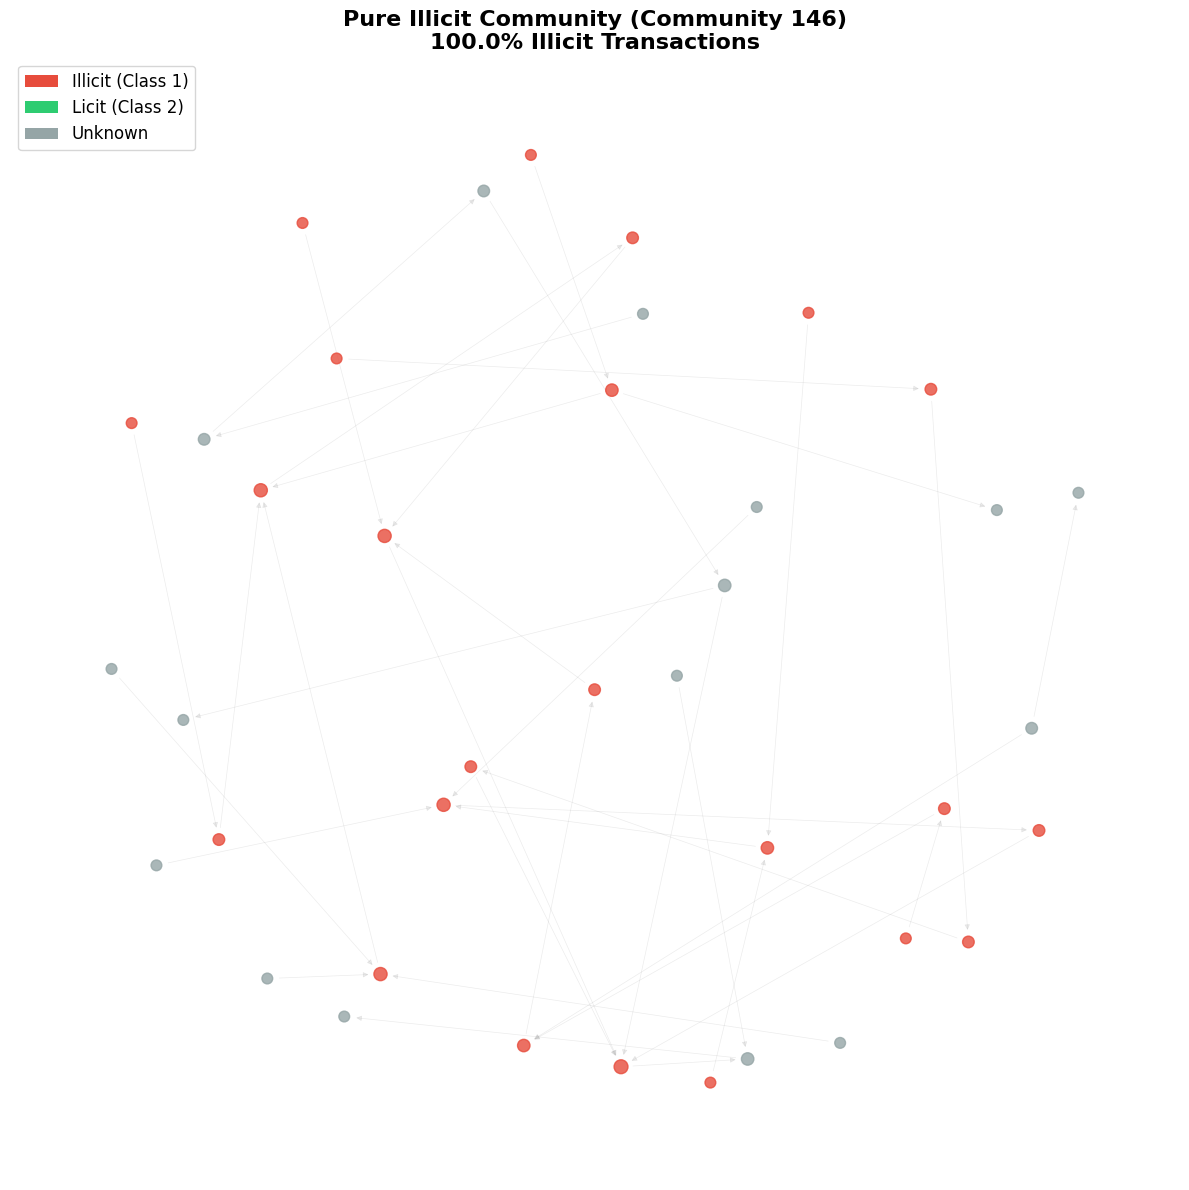


This community represents a potential fraud ring or money laundering network!


In [41]:
# Visualization 2: Focus on a pure illicit community (if exists)
if pure_illicit > 0:
    # Find a pure illicit community
    illicit_community = None
    for comm_id, stats in sorted_by_illicit:
        if stats['illicit_pct'] > 0.8 and stats['size'] > 20:
            illicit_community = comm_id
            break
    
    if illicit_community:
        # Get nodes from this community
        illicit_comm_nodes = [n for n, c in communities.items() if c == illicit_community]
        G_illicit = G.subgraph(illicit_comm_nodes[:100]).copy()  # Limit to 100 nodes
        
        print(f"\nVisualizing pure illicit community {illicit_community}")
        print(f"  Size: {len(illicit_comm_nodes)} nodes (showing first 100)")
        print(f"  Illicit %: {community_label_stats[illicit_community]['illicit_pct']*100:.1f}%")
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        
        # Layout
        pos = nx.spring_layout(G_illicit, k=1.0, iterations=50, seed=42)
        
        # Node colors and sizes
        node_colors = []
        node_sizes = []
        for node in G_illicit.nodes():
            label = G_illicit.nodes[node].get('label', 'unknown')
            if label == '1':
                node_colors.append('#e74c3c')  # Red for illicit (class 1)
            elif label == '2':
                node_colors.append('#2ecc71')  # Green for licit (class 2)
            else:
                node_colors.append('#95a5a6')  # Gray for unknown
            
            # Size by degree
            deg = G_illicit.degree(node)
            node_sizes.append(50 + deg * 10)
        
        nx.draw_networkx_nodes(G_illicit, pos, node_color=node_colors, 
                              node_size=node_sizes, alpha=0.8, ax=ax)
        nx.draw_networkx_edges(G_illicit, pos, alpha=0.15, arrows=True, 
                              arrowsize=8, width=0.5, edge_color='gray', ax=ax)
        
        # Add legend
        legend_elements = [
            Patch(facecolor='#e74c3c', label='Illicit (Class 1)'),
            Patch(facecolor='#2ecc71', label='Licit (Class 2)'),
            Patch(facecolor='#95a5a6', label='Unknown')
        ]
        ax.legend(handles=legend_elements, loc='upper left', fontsize=12)
        ax.set_title(f'Pure Illicit Community (Community {illicit_community})\n' + 
                    f'{community_label_stats[illicit_community]["illicit_pct"]*100:.1f}% Illicit Transactions',
                    fontsize=16, fontweight='bold')
        ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("\nThis community represents a potential fraud ring or money laundering network!")
    else:
        print("\nNo suitable pure illicit community found for visualization")
else:
    print("\nNo pure illicit communities detected")

In [42]:
# Visualization 3: Interactive network visualization using pyvis (optional but powerful)
print("Creating interactive network visualization...")
print("Note: This creates an HTML file you can open in a browser for interactive exploration")

try:
    from pyvis.network import Network
    
    # Create a smaller sample for interactive viz
    sample_nodes = list(G_sample.nodes())[:200]  # Limit to 200 nodes for performance
    G_interactive = G.subgraph(sample_nodes).copy()
    
    # Create pyvis network
    net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', 
                  notebook=True, directed=True)
    
    # Add nodes with colors
    for node in G_interactive.nodes():
        label_str = G_interactive.nodes[node].get('label', 'unknown')
        comm = communities.get(node, -1)
        
        # Color by fraud label
        if label_str == '1':
            color = '#e74c3c'
            label_text = 'Illicit (Class 1)'
        elif label_str == '2':
            color = '#2ecc71'
            label_text = 'Licit (Class 2)'
        else:
            color = '#95a5a6'
            label_text = 'Unknown'
        
        # Size by degree
        deg = G_interactive.degree(node)
        size = 10 + deg * 2
        
        title = f"Node: {node}\\nLabel: {label_text}\\nCommunity: {comm}\\nDegree: {deg}"
        net.add_node(node, label=str(node), color=color, size=size, title=title)
    
    # Add edges
    for source, target in G_interactive.edges():
        net.add_edge(source, target, color='rgba(255,255,255,0.1)')
    
    # Physics options for better layout
    net.set_options("""
    {
      "physics": {
        "forceAtlas2Based": {
          "gravitationalConstant": -50,
          "centralGravity": 0.01,
          "springLength": 100,
          "springConstant": 0.08
        },
        "maxVelocity": 50,
        "solver": "forceAtlas2Based",
        "timestep": 0.35,
        "stabilization": {"iterations": 150}
      }
    }
    """)
    
    # Save and display
    html_file = "transaction_network_interactive.html"
    net.show(html_file)
    
    print(f"✓ Interactive visualization saved to: {html_file}")
    print("  Open this file in a browser to explore the network interactively")
    print("  - Hover over nodes to see details")
    print("  - Click and drag to move nodes")
    print("  - Scroll to zoom in/out")
    
except ImportError:
    print("⚠ pyvis not installed. Run: pip install pyvis")
    print("  This enables interactive network visualizations in HTML")

Creating interactive network visualization...
Note: This creates an HTML file you can open in a browser for interactive exploration
transaction_network_interactive.html
✓ Interactive visualization saved to: transaction_network_interactive.html
  Open this file in a browser to explore the network interactively
  - Hover over nodes to see details
  - Click and drag to move nodes
  - Scroll to zoom in/out


# Overall Project Viability Assessment

In [43]:
# Final assessment for ML project viability
print("="*70)
print("FINAL ASSESSMENT: ML PROJECT VIABILITY FOR FRAUD DETECTION")
print("="*70)

scores = {
    'connectedness': 0,
    'homophily': 0,
    'degree_separation': 0,
    'community_structure': 0
}

# Score each dimension (0-3 scale)
print("\n1. GRAPH CONNECTIVITY & CHAIN LENGTH")
largest_component_pct = len(max(weakly_connected, key=len)) / G.number_of_nodes()
if largest_component_pct > 0.8:
    scores['connectedness'] = 3
    print(f"   ✓✓✓ Excellent ({largest_component_pct*100:.1f}% in largest component)")
elif largest_component_pct > 0.5:
    scores['connectedness'] = 2
    print(f"   ✓✓  Good ({largest_component_pct*100:.1f}% in largest component)")
else:
    scores['connectedness'] = 1
    print(f"   ✓   Fair ({largest_component_pct*100:.1f}% in largest component)")

print("\n2. HOMOPHILY (Do fraudulent nodes cluster?)")
if assortativity > 0.3:
    scores['homophily'] = 3
    print(f"   ✓✓✓ Excellent (assortativity={assortativity:.3f})")
elif assortativity > 0.1:
    scores['homophily'] = 2
    print(f"   ✓✓  Good (assortativity={assortativity:.3f})")
elif assortativity > 0:
    scores['homophily'] = 1
    print(f"   ✓   Fair (assortativity={assortativity:.3f})")
else:
    scores['homophily'] = 0
    print(f"   ✗   Poor (assortativity={assortativity:.3f}) - heterophilic")

print("\n3. DEGREE DISTRIBUTION (Structural differences)")
if p_in < 0.001 or p_out < 0.001:
    scores['degree_separation'] = 3
    print(f"   ✓✓✓ Excellent (p-value < 0.001) - highly discriminative")
elif p_in < 0.05 or p_out < 0.05:
    scores['degree_separation'] = 2
    print(f"   ✓✓  Good (p-value < 0.05) - statistically significant")
else:
    scores['degree_separation'] = 1
    print(f"   ✓   Fair (p-value >= 0.05)")

print("\n4. COMMUNITY STRUCTURE")
if modularity > 0.5 and avg_purity > 0.7:
    scores['community_structure'] = 3
    print(f"   ✓✓✓ Excellent (modularity={modularity:.3f}, purity={avg_purity:.3f})")
elif modularity > 0.3:
    scores['community_structure'] = 2
    print(f"   ✓✓  Good (modularity={modularity:.3f}, purity={avg_purity:.3f})")
else:
    scores['community_structure'] = 1
    print(f"   ✓   Fair (modularity={modularity:.3f})")

total_score = sum(scores.values())
max_score = 12

print("\n" + "="*70)
print(f"OVERALL SCORE: {total_score}/{max_score} ({total_score/max_score*100:.0f}%)")
print("="*70)

if total_score >= 10:
    verdict = "HIGHLY RECOMMENDED"
    color = "🟢"
elif total_score >= 7:
    verdict = "RECOMMENDED"
    color = "🟡"
else:
    verdict = "PROCEED WITH CAUTION"
    color = "🟠"

print(f"\n{color} PROJECT VIABILITY: {verdict}")
print("\nRECOMMENDATIONS:")

if scores['homophily'] >= 2:
    print("✓ GCNs are well-suited - strong homophily supports message passing")
else:
    print("⚠ Consider heterophily-aware GNN architectures (H2GCN, LINKX)")

if scores['community_structure'] >= 2:
    print("✓ Use community detection features as additional node attributes")
    
if pure_illicit > 0:
    print(f"✓ Investigate {pure_illicit} pure illicit communities for fraud patterns")

if scores['connectedness'] >= 2:
    print("✓ Graph sampling strategies (GraphSAINT, ClusterGCN) will work well")

print("\nSUGGESTED MODEL ARCHITECTURES:")
print("  1. Graph Convolutional Network (GCN)")
print("  2. GraphSAGE (with neighbor sampling)")
print("  3. Graph Attention Network (GAT) - to learn edge importance")
if modularity > 0.3:
    print("  4. Community-aware GNN - leverage detected communities")

FINAL ASSESSMENT: ML PROJECT VIABILITY FOR FRAUD DETECTION

1. GRAPH CONNECTIVITY & CHAIN LENGTH
   ✓   Fair (3.9% in largest component)

2. HOMOPHILY (Do fraudulent nodes cluster?)
   ✓✓✓ Excellent (assortativity=0.516)

3. DEGREE DISTRIBUTION (Structural differences)
   ✓✓✓ Excellent (p-value < 0.001) - highly discriminative

4. COMMUNITY STRUCTURE
   ✓✓✓ Excellent (modularity=0.980, purity=0.937)

OVERALL SCORE: 10/12 (83%)

🟢 PROJECT VIABILITY: HIGHLY RECOMMENDED

RECOMMENDATIONS:
✓ GCNs are well-suited - strong homophily supports message passing
✓ Use community detection features as additional node attributes
✓ Investigate 6 pure illicit communities for fraud patterns

SUGGESTED MODEL ARCHITECTURES:
  1. Graph Convolutional Network (GCN)
  2. GraphSAGE (with neighbor sampling)
  3. Graph Attention Network (GAT) - to learn edge importance
  4. Community-aware GNN - leverage detected communities


In [3]:
feature_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv")

In [6]:
feature_df.head()

,230425980,1,-0.1714692896288031,-0.18466755143291433,-1.2013688016765636,-0.12196959975910057,-0.04387454791734898,-0.11300200928476244,-0.06158379407303222,-0.16209679981659642,...,-0.5621534802884299,-0.6009988905192808,1.4613303209554889,1.4613689382001922,0.01827940003744589,-0.0874901561101501,-0.13115530389558736,-0.09752359377152515,-0.12061340670311574,-0.11979245961251665
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


In [7]:
feature_df.columns

Index(['230425980', '1', '-0.1714692896288031', '-0.18466755143291433',
       '-1.2013688016765636', '-0.12196959975910057', '-0.04387454791734898',
       '-0.11300200928476244', '-0.06158379407303222', '-0.16209679981659642',
       ...
       '-0.5621534802884299', '-0.6009988905192808', '1.4613303209554889',
       '1.4613689382001922', '0.01827940003744589', '-0.0874901561101501',
       '-0.13115530389558736', '-0.09752359377152515', '-0.12061340670311574',
       '-0.11979245961251665'],
      dtype='object', length=167)